For this notebook, do the fitting on just the bounding box for each footprint, rather than the entire image.

11a. added a background (linear) gradient to the fitting of the pre-subtraction images (see notebook 8f.)

This notebook will try to use heavy footprints to get the data to measure on, rather than sub-boxxing the images. Then we could just use the SFM framework. The question is can we pass heavy footprints that contain subimages from all three images (two pre-sub. and one difference image)?

Things still TBD for this are:
    
1. check if there is a gradient that needs to be fit
2. better estimate of starting parameters for gradient
3. better estimate for starting flux when there's a strong gradient
4. separate parameters for pos- and neg- images?
5. need to return chisq/dof and assess quality of fit, set "isDipole" flag.
6. need to ignore flagged pixels
7. investigate effects of covariances between pre-sub and difference images.
    
Also we have yet to figure out how to get our SFM plugin to work on more than one exposure (i.e. diffim *and*
pre-subtraction images) simultaneously.

In [170]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

def display2dArray(arr, title='Data', showBars=True, extent=None):
    img = plt.imshow(arr, origin='lower', interpolation='none', cmap='gray', extent=extent)
    plt.title(title)
    if showBars: plt.colorbar(img, cmap='gray')

def displayImage(image, showBars=True, width=8, height=2.5):
    plt.figure(figsize=(width, height))
    bbox = image.getBBox()
    extent = (bbox.getBeginX(), bbox.getEndX(), bbox.getBeginY(), bbox.getEndY())
    plt.subplot(1, 3, 1)
    ma = image.getArray()
    display2dArray(ma, title='Data', showBars=showBars, extent=extent)

def displayMaskedImage(maskedImage, showMasks=True, showVariance=False, showBars=True, width=8, height=2.5):
    plt.figure(figsize=(width, height))
    bbox = maskedImage.getBBox()
    extent = (bbox.getBeginX(), bbox.getEndX(), bbox.getBeginY(), bbox.getEndY())
    plt.subplot(1, 3, 1)
    ma = maskedImage.getArrays()
    display2dArray(ma[0], title='Data', showBars=showBars, extent=extent)
    if showMasks:
        plt.subplot(1, 3, 2)
        display2dArray(ma[1], title='Masks', showBars=showBars, extent=extent)
    if showVariance:
        plt.subplot(1, 3, 3)
        display2dArray(ma[2], title='Variance', showBars=showBars, extent=extent)
        
def displayExposure(exposure, showMasks=True, showVariance=False, showPsf=False, showBars=True, width=8, height=2.5):
#    plt.figure(figsize=(width, height))
#    plt.subplot(1, 3, 1)
#    ma = exposure.getMaskedImage().getArrays()
#    display2dArray(ma[0], title='Data', showBars=showBars)
#    if showMasks:
#        plt.subplot(1, 3, 2)
#        display2dArray(ma[1], title='Masks', showBars=showBars)
#    if showVariance and not showPsf:
#        plt.subplot(1, 3, 3)
#        display2dArray(ma[2], title='Variance', showBars=showBars)
    displayMaskedImage(exposure.getMaskedImage(), showMasks, showVariance=not showPsf, showBars=showBars, 
                       width=width, height=height)
    if showPsf:
        plt.subplot(1, 3, 3)
        psfIm = exposure.getPsf().computeImage()
        bbox = psfIm.getBBox()
        extent = (bbox.getBeginX(), bbox.getEndX(), bbox.getBeginY(), bbox.getEndY())
        display2dArray(psfIm.getArray(), title='PSF', showBars=showBars, extent=extent)

In [171]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim
import lsst.meas.modelfit as measMF

100.0
2.0
4.18796e+06


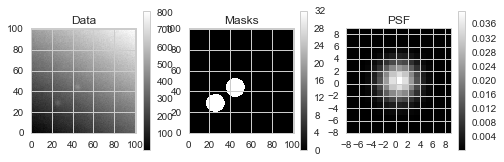

In [220]:
from lsst.meas.base.tests import TestDataset
#from meas_base_tests import TestDataset   ## my slightly modified version
import lsst.afw.geom as afwGeom

def makeStarImage_lsst(w=101, h=101, xc=[15.3], yc=[18.6], flux=[2500], psfSigma=2., noise=1.0, 
                       gradientParams=None, schema=None):
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(w-1, h-1))
    dataset = TestDataset(bbox, psfSigma=psfSigma, threshold=1.)
    for i in xrange(len(xc)):
        dataset.addSource(flux=flux[i], centroid=afwGeom.Point2D(xc[i], yc[i]))
    if schema is None:
        schema = TestDataset.makeMinimalSchema()
    exposure, catalog = dataset.realize(noise=noise, schema=schema)
    if gradientParams is not None:
        imgArr = exposure.getMaskedImage().getArrays()[0]
        y, x = np.mgrid[:w, :h]
        gp = gradientParams
        gradient = gp[0] + gp[1] * x + gp[2] * y
        imgArr += gradient
    return exposure, catalog

## Don't put sources too close to the edge!
## Test it on blended sources...
#exposure, catalog = makeStarImage_lsst(xc=[15.3,34.2], yc=[18.6, 33.5], flux=[2500., 2345.], noise=10.)
exposure, catalog = makeStarImage_lsst(xc=[25.3,44.2], yc=[28.6, 43.5], flux=[2500., 2345.], noise=10., 
                                       gradientParams=(10., 3., 5.))
displayExposure(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
print exposure.getPsf().computeShape().getDeterminantRadius()
print exposure.getMaskedImage().getArrays()[0].sum()

In [221]:
def makeHeavyCatalog(catalog, exposure, verbose=False):
    for source in catalog:
        fp = source.getFootprint()
        if not fp.isHeavy():
            if verbose:
                print 'not heavy => heavy'
            hfp = afwDet.HeavyFootprintF(fp, exposure.getMaskedImage())
            source.setFootprint(hfp)
            
    return catalog

## Oops, looks like there is a FootprintSet.makeHeavy()
#catalog.makeHeavy(exposure)
catalog = makeHeavyCatalog(catalog, exposure, True)

def getHeavyFootprintSubimage(fp, display=False):
    hfp = afwDet.HeavyFootprintF_cast(fp)
    bbox = hfp.getBBox()

    subim2 = afwImage.ImageF(bbox)
    subim2.getArray()[:,:] = np.nan
    afwDet.expandArray(hfp, hfp.getImageArray(), subim2.getArray(), bbox.getCorners()[0])
    if display:
        displayImage(subim2)
    return subim2

not heavy => heavy
not heavy => heavy


True


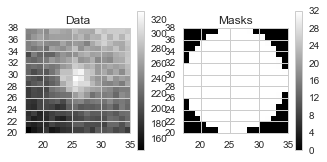

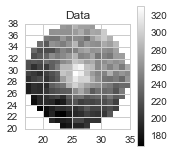

In [222]:
source = catalog[0]
fp = source.getFootprint()
print fp.isHeavy()

import lsst.afw.detection as afwDet
hfp = afwDet.HeavyFootprintF(fp, exposure.getMaskedImage())
bbox = hfp.getBBox()

subim = exposure.getMaskedImage().Factory(exposure.getMaskedImage(), bbox, afwImage.PARENT)
displayMaskedImage(subim)

_ = getHeavyFootprintSubimage(fp, display=True)

(101, 101)
200.0
100.0
100.0


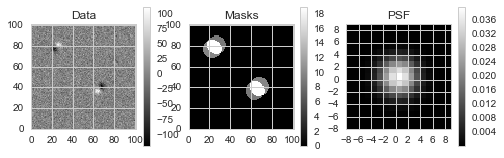

In [223]:
def makeDipoleImage_lsst(w=101, h=101, xcenPos=[27.], ycenPos=[25.], xcenNeg=[23.], ycenNeg=[25.], psfSigma=2., 
                         flux=[30000.], fluxNeg=[None], noise=10., gradientParams=None):
    
    posImage, posCatalog = makeStarImage_lsst(w, h, xcenPos, ycenPos, flux=flux, psfSigma=psfSigma, 
                                              gradientParams=gradientParams, noise=noise)
    if fluxNeg is None:
        fluxNeg = flux
    negImage, negCatalog = makeStarImage_lsst(w, h, xcenNeg, ycenNeg, flux=fluxNeg, psfSigma=psfSigma, 
                                              gradientParams=gradientParams, noise=noise)
    
    dipole = posImage.clone()
    di = dipole.getMaskedImage()
    di -= negImage.getMaskedImage()
    
    ## Carry through pos/neg detection masks to new planes in diffim image
    dm = di.getMask()
    posDetectedBits = posImage.getMaskedImage().getMask().getArray() == dm.getPlaneBitMask("DETECTED")
    negDetectedBits = negImage.getMaskedImage().getMask().getArray() == dm.getPlaneBitMask("DETECTED")
    pos_det = dm.addMaskPlane("DETECTED_POS") ## new mask plane -- this is different from "DETECTED"
    neg_det = dm.addMaskPlane("DETECTED_NEG") ## new mask plane -- this is different from "DETECTED_NEGATIVE"
    dma = dm.getArray()
    dma[:,:] = posDetectedBits * pos_det + negDetectedBits * neg_det  ## set the two custom mask planes to these masks
    return dipole, (posImage, posCatalog), (negImage, negCatalog)

npa = np.array
xc = npa([65.3, 24.2])
yc = npa([38.6, 78.5])
flux = npa([2500., 2345.])
dipole, (posImage, posCatalog), (negImage, negCatalog) = \
    makeDipoleImage_lsst(xcenPos=xc + npa([-2., +2.]), ycenPos=yc + npa([-2., +2.]), 
                         xcenNeg=xc - npa([-2., +2.]), ycenNeg=yc - npa([-2., +2.]), 
                         flux=flux, fluxNeg=flux, gradientParams=(10., 3., 5.))
displayExposure(dipole, showPsf=True)
print dipole.getMaskedImage().getArrays()[0].shape
print dipole.getMaskedImage().getArrays()[2].mean()
print posImage.getMaskedImage().getArrays()[2].mean()
print negImage.getMaskedImage().getArrays()[2].mean()

not heavy => heavy
not heavy => heavy
True


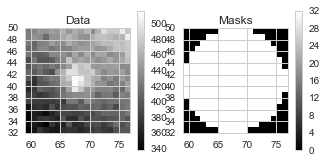

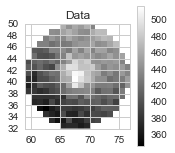

In [224]:
catalog = makeHeavyCatalog(negCatalog, negImage, True)

source = negCatalog[0]
fp = source.getFootprint()
print fp.isHeavy()

import lsst.afw.detection as afwDet
hfp = afwDet.HeavyFootprintF(fp, negImage.getMaskedImage())
bbox = hfp.getBBox()

subim = negImage.getMaskedImage().Factory(negImage.getMaskedImage(), bbox, afwImage.PARENT)
displayMaskedImage(subim)

_ = getHeavyFootprintSubimage(fp, display=True)

In [225]:
cat2 = makeHeavyCatalog(catalog, exposure, verbose=True)

Code taken from Jim Bosch's "measurement" bootcamp talk...

https://github.com/lsst-dm/Oct15_bootcamp/blob/measurement/measurement/new-plugin-1.ipynb

In [226]:
import lsst.meas.base
import lsst.pex.config
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender

In [227]:
# We have to initialize all tasks before using any of them:
# multiple tasks will write to the same Schema, and we can't create an output 
# catalog until we've finished defining that Schema.

# Start with a minimal schema - only the fields all SourceCatalogs need
schema = lsst.afw.table.SourceTable.makeMinimalSchema()

Detect sources in the pos- and neg- images separately. Already done above. Try deblending on them.

In [228]:
# Create and run a task for deblending (optional, but almost always a good idea). 
# Again, the task defines a few flag fields it will later fill. 
deblendTask = lsst.meas.deblender.SourceDeblendTask(schema=schema)

deblendTask.run(posImage, posCatalog, psf=posImage.getPsf())
deblendTask.run(negImage, negCatalog, psf=negImage.getPsf())

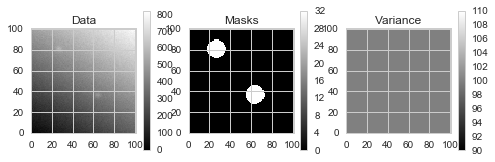

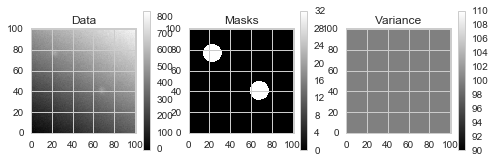

In [229]:
posCatalog = makeHeavyCatalog(posCatalog, posImage)
negCatalog = makeHeavyCatalog(negCatalog, negImage)

displayExposure(posImage)
displayExposure(negImage)

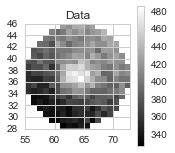

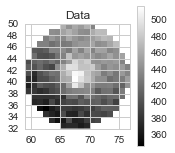

In [230]:
#### Positive image footprint

_ = getHeavyFootprintSubimage(posCatalog[0].getFootprint(), display=True)

#### Negative image footprint

_ = getHeavyFootprintSubimage(negCatalog[0].getFootprint(), display=True)

Detect positive and negative sources in the imDiff, then merge them (some code [noted] taken from `lsst/pipe/tasks/imageDifference.py`)

In [231]:
# Customize the detection task a bit (optional)
detectConfig = lsst.meas.algorithms.SourceDetectionConfig() 
detectConfig.returnOriginalFootprints = False # should be the default 
detectConfig.thresholdValue = 10 # only 10-sigma detections

## code from imageDifference.py:
detectConfig.thresholdPolarity = "both"
detectConfig.thresholdValue = 5.5
detectConfig.reEstimateBackground = False
detectConfig.thresholdType = "pixel_stdev"

# Create the detection task. We pass the schema so the task can declare a few flag fields
detectTask = lsst.meas.algorithms.SourceDetectionTask(config=detectConfig, schema=schema)

table = lsst.afw.table.SourceTable.make(schema)
detectResult = detectTask.run(table, dipole)
catalog = detectResult.sources
#results = detectTask.makeSourceCatalog(table, exposure, sigma=psfSigma)

deblendTask.run(dipole, catalog, psf=dipole.getPsf())

In [232]:
catalog = makeHeavyCatalog(catalog, dipole, verbose=True)

not heavy => heavy
not heavy => heavy
not heavy => heavy
not heavy => heavy


Now do the merge. Make sure to only do this once! If you need to re-run it, then re-run the 2 cells above as well.

In [233]:
print len(detectResult.sources), detectResult.fpSets.numPos, detectResult.fpSets.numNeg
fpSet = detectResult.fpSets.positive
fpSet.merge(detectResult.fpSets.negative, 2, 2, False)
sources = afwTable.SourceCatalog(table)
fpSet.makeSources(sources)
print type(fpSet), type(detectResult.sources), type(detectResult.fpSets.positive)

4 2 2
<class 'lsst.afw.detection.detectionLib.FootprintSet'> <class 'lsst.afw.table.tableLib.SourceCatalog'> <class 'lsst.afw.detection.detectionLib.FootprintSet'>


In [239]:
for s in sources:
    fp = s.getFootprint()
    print fp.isHeavy(), fp.getNpix()
    for pk in fp.getPeaks():
        print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx(), pk.getPeakValue()

True 486
FOOTPRINT CENTER: 36 63 47.2880058289
FOOTPRINT CENTER: 41 68 -43.9519805908
True 468
FOOTPRINT CENTER: 81 27 41.5934066772
FOOTPRINT CENTER: 76 22 -39.3666725159


not heavy => heavy
not heavy => heavy


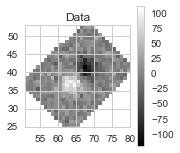

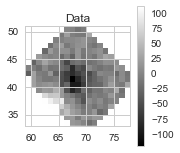

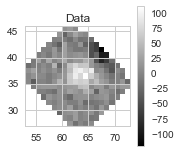

In [235]:
sources = makeHeavyCatalog(sources, dipole, verbose=True)

##### Dipole footprint

_ = getHeavyFootprintSubimage(sources[0].getFootprint(), display=True)

#### Positive sub-footprint

_ = getHeavyFootprintSubimage(catalog[0].getFootprint(), display=True)

#### Negative sub-footprint

_ = getHeavyFootprintSubimage(catalog[2].getFootprint(), display=True)

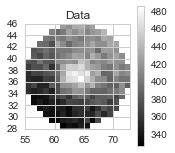

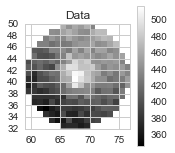

In [236]:
#### Positive image footprint

_ = getHeavyFootprintSubimage(posCatalog[0].getFootprint(), display=True)

#### Negative image footprint

_ = getHeavyFootprintSubimage(negCatalog[0].getFootprint(), display=True)

## Example BoxFluxPlugin

In [12]:
class BoxFluxConfig(lsst.meas.base.SingleFramePluginConfig):
    
    width = lsst.pex.config.Field(
        dtype=int, default=30,
        doc="approximate width of rectangular aperture"
    )

    height = lsst.pex.config.Field(
        dtype=int, default=30,
        doc="approximate height of rectangular aperture"
    )
    
class BoxFluxTransform(lsst.meas.base.FluxTransform):

    def __init__(self, config, name, mapper):
        lsst.meas.base.FluxTransform.__init__(self, name, mapper)
        mapper.addMapping(mapper.getInputSchema().find(name + "_flag_edge").key)

        
## @lsst.meas.base.deregister() doesn't exist, so let's do this first...        
try:    
    del lsst.meas.base.SingleFramePlugin.registry._dict["ext_BoxFlux"]
except:
    pass

@lsst.meas.base.register("ext_BoxFlux")
class BoxFluxPlugin(lsst.meas.base.SingleFramePlugin):

    ConfigClass = BoxFluxConfig
    
    FAILURE_EDGE = 1

    @classmethod
    def getExecutionOrder(cls):
        return cls.FLUX_ORDER

    @classmethod
    def getTransformClass(cls):
        return BoxFluxTransform
    
    def __init__(self, config, name, schema, metadata):
        lsst.meas.base.SingleFramePlugin.__init__(self, config, name, schema, metadata)

        # Get a FunctorKey that can quickly look up the "blessed" centroid value.
        self.centroidKey = lsst.afw.table.Point2DKey(schema["slot_Centroid"])

        # Add some fields for our outputs, and save their Keys.
        doc = "flux in a {0.width} x {0.height} rectangle".format(self.config)
        self.fluxKey = schema.addField(
            schema.join(name, "flux"), type=float, units="dn", doc=doc
        )
        self.fluxSigmaKey = schema.addField(
            schema.join(name, "fluxSigma"), type=float, units="dn",
            doc="1-sigma uncertainty for BoxFlux"
        )
        self.flagKey = schema.addField(
            schema.join(name, "flag"), type="Flag",
            doc="general failure flag for BoxFlux"
        )
        self.edgeFlagKey = schema.addField(
            schema.join(name, "flag", "edge"), type="Flag",
            doc="flag set when rectangle used by BoxFlux doesn't fit in the image"
        )
    
    def measure(self, measRecord, exposure):

        centroid = measRecord.get(self.centroidKey)
    
        # Create a single-pixel box
        point = lsst.afw.geom.Point2I(centroid)
        box = lsst.afw.geom.Box2I(point, point)

        # Grow the box in the desired size
        box.grow(lsst.afw.geom.Extent2I(self.config.width // 2, self.config.height // 2))

        # Horrible syntax to create a subimage.  Can't use [] because it doesn't pay
        # attention to xy0 :-(
        try: 
            subMaskedImage = exposure.getMaskedImage().Factory(
                exposure.getMaskedImage(),
                box,
                lsst.afw.image.PARENT
            )
        except lsst.pex.exceptions.LengthError as err:
            raise lsst.meas.base.MeasurementError(str(err), self.FAILURE_EDGE)

        # compute the flux by extracting and summing NumPy arrays.
        flux = subMaskedImage.getImage().getArray().sum()
        fluxSigma = subMaskedImage.getVariance().getArray().sum()**0.5
        
        print flux, fluxSigma

        measRecord[self.fluxKey] = flux
        measRecord[self.fluxSigmaKey] = fluxSigma
        
    def fail(self, measRecord, error=None):
        measRecord.set(self.flagKey, True)
        if error is not None:
            assert error.getFlagBit() == self.FAILURE_EDGE
            measRecord.set(self.edgeFlagKey, True)

Try using existing ip_diffim dipole measurement task.

F**ck it, let's just write our plugin.

In [13]:
from collections import namedtuple
resultsOutput = namedtuple('resultsOutput', 
        ['psfFitPosCentroidX', 'psfFitPosCentroidY', 'psfFitNegCentroidX', 'psfFitNegCentroidY', 'psfFitPosFlux', 
         'psfFitNegFlux', 'psfFitCentroidX', 'psfFitCentroidY', 'psfFitOrientation', 'psfFitSignaltoNoise'])

def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, fluxNeg=None, 
               b=None, x1=None, y1=None, **kwargs):
    """
    Dipole based on image's psf. Image is passed as kwargs['diffim']
    dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, fluxNeg)
    """
    #diffim = kwargs.get('diffim')
    psf = kwargs.get('psf') #diffim.getPsf()
    rel_weight = kwargs.get('rel_weight')
    fp = kwargs.get('footprint')
    bbox = fp.getBBox()
    
    if fluxNeg is None:
        fluxNeg = flux

    gradientImage = None
    if b is not None and abs(b)+abs(x1)+abs(y1) > 0.:
        y, x = np.mgrid[bbox.getBeginY():bbox.getEndY(), bbox.getBeginX():bbox.getEndX()]
        gradient = b + x1 * x + y1 * y
        ## this type of constructor should be possible, but I can't get it to work:
        ## __init__(lsst::afw::image::Image<(float)> self, ndarray::Array< float,2,1 > const & array, 
        ##          bool deep=False, Point2I xy0=lsst::afw::geom::Point2I()) -> ImageF
        gradientImage = afwImage.ImageF(bbox)
        gradientImage.getArray()[:,:] = gradient
    
    p_pos = psf.computeImage(afwGeom.Point2D(xcenPos, ycenPos)).convertF()
    p_pos_sum = np.sum(p_pos.getArray())
    p_pos *= (flux/p_pos_sum)
    p_neg = psf.computeImage(afwGeom.Point2D(xcenNeg, ycenNeg)).convertF()
    p_neg_sum = np.sum(p_neg.getArray())
    p_neg *= (fluxNeg/p_neg_sum)
    
    pos_box = p_pos.getBBox()
    neg_box = p_neg.getBBox()
    
    ## Clip the PSF image bounding boxes to fall within the footprint bounding box
    pos_box.clip(bbox)
    neg_box.clip(bbox)

    ## Then actually crop the psf images. 
    ## Usually not necessary, but if the dipole is near the edge of the image...
    ## Would be nice if we could compare original pos_box with clipped pos_box and see if it actually was clipped.
    p_pos = afwImage.ImageF(p_pos, pos_box, afwImage.PARENT)
    p_neg = afwImage.ImageF(p_neg, neg_box, afwImage.PARENT)

    posIm = afwImage.ImageF(bbox)
    tmpSubim = afwImage.ImageF(posIm, pos_box, afwImage.PARENT)
    tmpSubim += p_pos

    negIm = afwImage.ImageF(bbox)
    tmpSubim = afwImage.ImageF(negIm, neg_box, afwImage.PARENT)
    tmpSubim += p_neg

    if gradientImage is not None:
        posIm += gradientImage
        negIm += gradientImage

    diffIm = afwImage.ImageF(bbox)
    diffIm += posIm
    diffIm -= negIm

    zout = diffIm.getArray()
    if rel_weight > 0.:
        zout = np.append([zout], [posIm.getArray(), negIm.getArray()], axis=0)
        
    return zout

def fitDipole(exposure, source, posImage=None, negImage=None, tol=1e-7, rel_weight=0.1, 
              fitBgGradient=True, centroidRangeInSigma=5., separateNegParams=True, 
              verbose=False, display=False):
    """
    fitDipole()
    """
    ## exposure is the imDiff.
    ## source is a source, with a footprint, from a catalog.
    ## separateNegParams --> separate flux (and TBD: gradient) params for negative img. 
    ## Otherwise same as posImage
    
    #posImage = negImage = None
    #if rel_weight > 0. and hasattr(exposure, '__iter__'):
    #    diffim, posImage, negImage = exposure    
    #else if 'lsst.afw.image.imageLib.Exposure' in str(type(exposure)):
    diffim = exposure
    
    fp = source.getFootprint()
    box = fp.getBBox()
    extent = (box.getBeginX(), box.getEndX(), box.getBeginY(), box.getEndY())
    subim = diffim.getMaskedImage().Factory(
                    diffim.getMaskedImage(), box, lsst.afw.image.PARENT)
    
    z = subim.getArrays()[0] ## allow passing of just diffim
    if posImage is not None:
        posSubim = posImage.getMaskedImage().Factory(
                        posImage.getMaskedImage(), box, lsst.afw.image.PARENT)
        negSubim = negImage.getMaskedImage().Factory(
                        negImage.getMaskedImage(), box, lsst.afw.image.PARENT)
        z = np.append([z], [posSubim.getArrays()[0], 
                        negSubim.getArrays()[0]], axis=0)
        
    #w, h = diffim.getWidth(), diffim.getHeight()
    psfSigma = diffim.getPsf().computeShape().getDeterminantRadius()
            
    gmod = lmfit.Model(dipoleFunc, verbose=verbose)

    pks = fp.getPeaks()
    cenPos = pks[0].getF() ##np.array(pks[0].getF()) #[::-1]  ## need to switch x,y ?? No.
    cenNeg = pks[1].getF() ##np.array(pks[1].getF()) #[::-1]  ## assume pos peak is first?

    ## For close/faint dipoles the starting locs (min/max) might be way off, let's help them a bit.
    ## First assume dipole is not separated by more than 5*psfSigma. 
    centroidRange = psfSigma * centroidRangeInSigma

    ## parameter hints/constraints: https://lmfit.github.io/lmfit-py/model.html#model-param-hints-section
    gmod.set_param_hint('xcenPos', value=cenPos[0], min=cenPos[0]-centroidRange, max=cenPos[0]+centroidRange)
    gmod.set_param_hint('ycenPos', value=cenPos[1], min=cenPos[1]-centroidRange, max=cenPos[1]+centroidRange)
    gmod.set_param_hint('xcenNeg', value=cenNeg[0], min=cenNeg[0]-centroidRange, max=cenNeg[0]+centroidRange)
    gmod.set_param_hint('ycenNeg', value=cenNeg[1], min=cenNeg[1]-centroidRange, max=cenNeg[1]+centroidRange)

    ## Estimate starting flux. This strongly affects runtime performance so we want to make it close.
    ## TBD: if this actually is what we end up using, then we can't sum over the entier image. 
    ## Need to use a localized region/footprint or bbox and know the local background from the image?.
    ## DONE, now we are just using the footprint bounding box.
    if posImage is not None:
        #startingFlux = (z[1,:] - np.median(z[1,:])).sum()   ## use the pos. image; subtract the background
        startingFlux = (np.abs(z[0,:]) - np.median(z[0,:])).sum() / 2.  ## use the dipole; subtract the background
    else:
        startingFlux = (np.abs(z) - np.median(z)).sum() / 2.  ## use the dipole for an estimate. Remove the background
        
    gmod.set_param_hint('flux', value=startingFlux, min=0.1) #, max=startingFlux * 2.)  ## TBD: set max. flux limit? 

    if separateNegParams:
        gmod.set_param_hint('fluxNeg', value=startingFlux, min=0.1) #, max=startingFlux * 2.)  ## TBD: same as above
    else:
        gmod.set_param_hint('fluxNeg', value=startingFlux, min=0.1, expr='flux')

    varyBgParams = (rel_weight > 0. and fitBgGradient)
           
    ## Fixed parameters (dont fit for them):
    gmod.set_param_hint('b', value=0., vary=varyBgParams)
    gmod.set_param_hint('x1', value=0., vary=varyBgParams)
    gmod.set_param_hint('y1', value=0., vary=varyBgParams)

    #y, x = np.mgrid[extent[0]:extent[1], extent[2]:extent[3]] #np.mgrid[:w, :h]
    #in_x = np.array([x, y])
    ## pass the dipole image's bounding box (extent) as input (lmfit makes sure it's an array)
    ## Note it's currently not used in dipoleFunc()
    in_x = np.array(extent)
    
    ## TBD: weight the data by 1/variance
    ## Weight the "pre-subtraction" planes by rel_weight (relative to the actual diffim plane)
    if posImage is not None:
        weights = np.array([np.ones_like(z[0,:]), np.ones_like(z[1,:])*rel_weight, np.ones_like(z[2,:])*rel_weight])
    else:
        weights = 1.
                
    result = gmod.fit(z, weights=weights,
                      x=in_x, 
                      #flux=startingFlux, fluxNeg=startingFlux, 
                      #xcenPos=cenPos[0], ycenPos=cenPos[1], 
                      #xcenNeg=cenNeg[0], ycenNeg=cenNeg[1], 
                      #b=0., x1=0., y1=0.,
                      verbose=verbose, #) #, sig1=1., sig2=2.)
                      fit_kws={'ftol':tol, 'xtol':tol, 'gtol':tol},
                      #diffim=subim, #diffim, 
                      psf=diffim.getPsf(),
                      rel_weight=rel_weight,
                      footprint=fp
                     )  
                      ## default fit method -- levenberg-marquardt ('leastsq')
                      #method='nelder',
                      #fit_kws={'tol':tol})
    
    if verbose and separateNegParams: 
        print result.fit_report(show_correl=False) 
        ## This is how to get confidence intervals out; 
        ##    see here: https://lmfit.github.io/lmfit-py/confidence.html and 
        ##    here: http://cars9.uchicago.edu/software/python/lmfit/model.html
        ## Note this calc takes a long time (longer than the fit!)
        print result.ci_report()

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        if posImage is not None:
            display2dArray(z[0,:], 'Data', True, extent=extent)
        else:
            display2dArray(z, 'Data', True, extent=extent)
        plt.subplot(1, 3, 2)
        if posImage is not None:
            display2dArray(result.best_fit[0,:], 'Model', True, extent=extent)
        else:
            display2dArray(result.best_fit, 'Model', True, extent=extent)
        plt.subplot(1, 3, 3)
        if posImage is not None:
            display2dArray(z[0,:] - result.best_fit[0,:], 'Residual', True, extent=extent)
        else:
            display2dArray(z - result.best_fit, 'Residual', True, extent=extent)

    return result

def fitDipole_new(exposure, source, posImage=None, negImage=None, tol=1e-7, rel_weight=0.1, 
                  return_fitObj=False, fitBgGradient=True, centroidRangeInSigma=5., 
                  separateNegParams=True, verbose=False, display=False):

    result = fitDipole(exposure, source=source, posImage=posImage, negImage=negImage, 
                       rel_weight=rel_weight, tol=tol, fitBgGradient=fitBgGradient,
                       centroidRangeInSigma=centroidRangeInSigma, 
                       separateNegParams=separateNegParams, verbose=verbose, display=display)

    results = result.best_values
    
    centroid = ((results['xcenPos']+results['xcenNeg'])/2., (results['ycenPos']+results['ycenNeg'])/2.)
    dx, dy = results['xcenPos'] - results['xcenNeg'], results['ycenPos'] - results['ycenNeg']
    angle = np.arctan2(dy, dx) / np.pi * 180.   ## convert to degrees (should keep as rad?)

    fluxVal, fluxErr = result.params['flux'].value, result.params['flux'].stderr
    fluxValNeg, fluxErrNeg = result.params['fluxNeg'].value, result.params['fluxNeg'].stderr
    signalToNoise = np.sqrt((fluxVal/fluxErr)**2 + (fluxValNeg/fluxErrNeg)**2) ## This is from DipoleAnalysis code
        
    out = resultsOutput(results['xcenPos'], results['ycenPos'], results['xcenNeg'], results['ycenNeg'],
                        fluxVal, -fluxValNeg, centroid[0], centroid[1], angle, signalToNoise)

    if not return_fitObj: 
        return out #.best_values
    return out, result

Box2I((52, 25), (78, 52)) 464
FOOTPRINT CENTER: 36 63 46.5962791443
FOOTPRINT CENTER: 41 68 -41.2247390747
Box2I((11, 65), (37, 92)) 481
FOOTPRINT CENTER: 81 26 41.2885055542
FOOTPRINT CENTER: 76 22 -43.3027153015
 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "fluxNeg"
 - Adding parameter for hint "b"
 - Adding parameter for hint "x1"
 - Adding parameter for hint "y1"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "fluxNeg"
 - Adding parameter "b"
 - Adding parameter "x1"
 - Adding parameter "y1"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 78
    # data points      = 2268
    # variables        = 9
    chi-square         = 290570.852
    reduced chi-square = 128.62

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument footprint does notmatch any arguments of the model function.It will be ignored.
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument rel_weight does notmatch any arguments of the model function.It will be ignored.
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument psf does notmatch any arguments of the model function.It will be ignored.


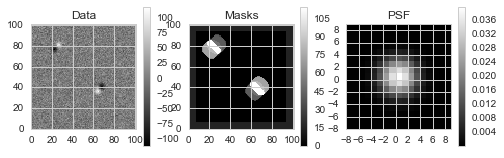

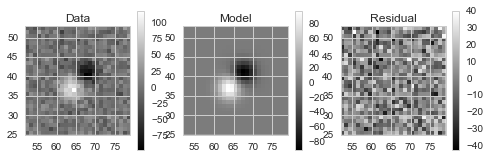

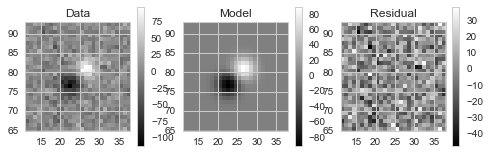

In [14]:
for s in sources:
    fp = s.getFootprint()
    print fp.getBBox(), fp.getNpix()
    for pk in fp.getPeaks():
        print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx(), pk.getPeakValue()

displayExposure(dipole, showPsf=True)

verbose = True
for s in sources:
    result = fitDipole_new(dipole, s, posImage, negImage, rel_weight=1., 
                           separateNegParams=verbose, 
                           verbose=verbose, display=True)
    verbose = False
    
#%timeit fitDipole_new((dipole, posImage, negImage), s, rel_weight=0., verbose=False, display=False)
#%timeit fitDipole_new(dipole, s, rel_weight=0., verbose=False, display=False)

print result

 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "fluxNeg"
 - Adding parameter for hint "b"
 - Adding parameter for hint "x1"
 - Adding parameter for hint "y1"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "fluxNeg"
 - Adding parameter "b"
 - Adding parameter "x1"
 - Adding parameter "y1"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 756
    # variables        = 6
    chi-square         = 142401.279
    reduced chi-square = 189.868
[[Variables]]
    xcenPos:   63.4317812 +/- 0.114196 (0.18%) (init= 63)
    ycenPos:   36.5248740 +/- 0.115137 (0.32%) (init= 36)
    xcenNeg:   67.1989297 +/- 0.126719 (0.19%) (init= 68)
    ycenNeg:   40.5112545

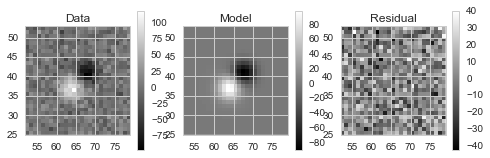

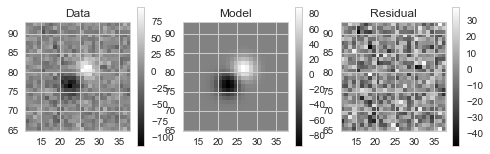

In [15]:
## Need to be able to do it without pre-subtracted images
verbose = True
for s in sources:
    result = fitDipole_new(dipole, s, verbose=verbose, separateNegParams=True, 
                           rel_weight=0., display=True)
    verbose = False

print '\n', result

In [16]:
## Need to be able to do it with pre-subtracted images but with bg. gradient fitting turned off
verbose = True
for s in sources:
    result = fitDipole_new(dipole, s, posImage, negImage, verbose=verbose, 
                           separateNegParams=True, fitBgGradient=False,
                           rel_weight=0.1, display=False)
    verbose = False

print '\n', result

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=-1.0 < 0.01  at iteration 2 and prob(xcenPos=64.1248267109) = 0.0 < max(sigmas).
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=-1.0 < 0.01  at iteration 3 and prob(ycenPos=37.4936074339) = 0.0 < max(sigmas).
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=-1.0 < 0.01  at iteration 2 and prob(xcenNeg=66.4597211702) = 0.0 < max(sigmas).
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=-1.0 < 0.01  at iteration 2 and prob(ycenNeg=39.765289985) = 0.0 < max(sigmas).
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Wa

 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "fluxNeg"
 - Adding parameter for hint "b"
 - Adding parameter for hint "x1"
 - Adding parameter for hint "y1"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "fluxNeg"
 - Adding parameter "b"
 - Adding parameter "x1"
 - Adding parameter "y1"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 66
    # data points      = 2268
    # variables        = 6
    chi-square         = 2563710.897
    reduced chi-square = 1133.382
[[Variables]]
    xcenPos:   63.6027805 +/- 0.261023 (0.41%) (init= 63)
    ycenPos:   36.7029477 +/- 0.263553 (0.72%) (init= 36)
    xcenNeg:   67.0313437 +/- 0.285811 (0.43%) (init= 68)
    ycenNeg:   40.3347

Huh, weird that running with `separateNegParams=False` (i.e., fewer params) is slower than with `True`.

In [17]:
%timeit fitDipole_new(dipole, sources[1], rel_weight=0.)
%timeit fitDipole_new(dipole, sources[1], rel_weight=0., separateNegParams=False)
%timeit fitDipole_new(dipole, sources[1], posImage, negImage, rel_weight=1.)
%timeit fitDipole_new(dipole, sources[1], posImage, negImage, rel_weight=1., separateNegParams=False)
%timeit fitDipole_new(dipole, sources[1], posImage, negImage, rel_weight=0.1, fitBgGradient=False)

100 loops, best of 3: 16.1 ms per loop
100 loops, best of 3: 17.7 ms per loop
10 loops, best of 3: 51.2 ms per loop
10 loops, best of 3: 33.3 ms per loop
10 loops, best of 3: 29.7 ms per loop


## Make the DipoleFitPlugin !!!

In [35]:
class DipoleFitConfig(lsst.meas.base.SingleFramePluginConfig):
    
    centroidRange = lsst.pex.config.Field(
        dtype=float, default=5.,
        doc="assume dipole is not separated by more than centroidRange*psfSigma"
    )

    relWeight = lsst.pex.config.Field(
        dtype=float, default=1., ##0.,
        doc="relative weighting of pre-subtraction images"
    )

    tolerance = lsst.pex.config.Field(
        dtype=float, default=1e-7,
        doc="fit tolerance"
    )

    fitBgGradient = lsst.pex.config.Field(
        dtype=bool, default=True,
        doc="fit separate parameters for linear gradient in pre-sub. images"
    )

    verbose = lsst.pex.config.Field(
        dtype=bool, default=False,
        doc="be verbose; this is slow"
    )

class DipoleFitTransform(lsst.meas.base.FluxTransform):

    def __init__(self, config, name, mapper):
        lsst.meas.base.FluxTransform.__init__(self, name, mapper)
        mapper.addMapping(mapper.getInputSchema().find(name + "_flag_edge").key)

        
## @lsst.meas.base.deregister() doesn't exist, so let's do this first...        
try:    
    del lsst.meas.base.SingleFramePlugin.registry._dict["ext_DipoleFit"]
except:
    pass

@lsst.meas.base.register("ext_DipoleFit")
class DipoleFitPlugin(lsst.meas.base.SingleFramePlugin):

    ConfigClass = DipoleFitConfig
    
    FAILURE_EDGE = 1

    @classmethod
    def getExecutionOrder(cls):
        return cls.FLUX_ORDER    ## algorithms that require both getShape() and getCentroid(),
                                 ## in addition to a Footprint and its Peaks

    @classmethod
    def getTransformClass(cls):
        return DipoleFitTransform
    
    def _setupSchema(self, config, name, schema, metadata):
        # Get a FunctorKey that can quickly look up the "blessed" centroid value.
        self.centroidKey = lsst.afw.table.Point2DKey(schema["slot_Centroid"])

        # Add some fields for our outputs, and save their Keys.
        # Use setAttr() to programmatically set the pos/neg named attributes to values, e.g. 
        # self.posCentroidKeyX = 'ext_DipoleFit_pos_centroid_x'
        
        for pos_neg in ['pos', 'neg']:

            key = schema.addField(
                schema.join(name, pos_neg, "flux"), type=float, units="dn", 
                doc="Dipole {0} lobe flux".format(pos_neg)
            )
            setattr(self, ''.join((pos_neg, 'FluxKey')), key)
            
            key = schema.addField(
                schema.join(name, pos_neg, "fluxSigma"), type=float, units="pixels",
                doc="1-sigma uncertainty for {0} dipole flux".format(pos_neg)
            )
            setattr(self, ''.join((pos_neg, 'FluxSigmaKey')), key)

            for x_y in ['x', 'y']:
                key = schema.addField(
                    schema.join(name, pos_neg, "centroid", x_y), type=float, units="pixels", 
                    doc="Dipole {0} lobe centroid".format(pos_neg)
                )
                setattr(self, ''.join((pos_neg, 'CentroidKey', x_y.upper())), key)

        for x_y in ['x', 'y']:
            key = schema.addField(
                schema.join(name, "centroid", x_y), type=float, units="pixels", 
                doc="Dipole centroid"
            )
            setattr(self, ''.join(('centroidKey', x_y.upper())), key)

        self.orientationKey = schema.addField(
            schema.join(name, "orientation"), type=float, units="deg", 
            doc="Dipole orientation"
        )

        self.flagKey = schema.addField(
            schema.join(name, "flag"), type="Flag",
            doc="general failure flag for dipole fit"
        )

        self.edgeFlagKey = schema.addField(
            schema.join(name, "flag", "edge"), type="Flag",
            doc="flag set when rectangle used by dipole doesn't fit in the image"
        )
        
    def __init__(self, config, name, schema, metadata):
        lsst.meas.base.SingleFramePlugin.__init__(self, config, name, schema, metadata)
        
        self._setupSchema(config, name, schema, metadata)

    def measure(self, measRecord, exposure, posImage=None, negImage=None):
        
        ## NOTE THIS IS NOT THE WAY I WANT TO DO THIS, ULTIMATELY!
        if posImage is None and hasattr(exposure, 'posImage'):
            posImage = exposure.posImage
        if negImage is None and hasattr(exposure, 'negImage'):
            negImage = exposure.negImage
                            
        try:
            result = fitDipole_new(exposure, measRecord, posImage=posImage, negImage=negImage,
                                   rel_weight=self.config.relWeight, 
                                   tol=self.config.tolerance, 
                                   centroidRangeInSigma=self.config.centroidRange,
                                   fitBgGradient=self.config.fitBgGradient,
                                   verbose=self.config.verbose, display=False)
        except lsst.pex.exceptions.LengthError as err:
            raise lsst.meas.base.MeasurementError(err, self.FAILURE_EDGE)

        ## TBD: add chi2, coord/flux uncertainties

        #psfFitPosCentroidX, psfFitPosCentroidY, psfFitNegCentroidX, psfFitNegCentroidY, psfFitPosFlux, 
        #psfFitNegFlux, psfFitCentroidX, psfFitCentroidY, psfFitOrientation, psfFitSignaltoNoise
        print result
        
        measRecord[self.posFluxKey] = result.psfFitPosFlux
        measRecord[self.posFluxSigmaKey] = result.psfFitSignaltoNoise   ## to be changed to actual sigma
        measRecord[self.posCentroidKeyX] = result.psfFitPosCentroidX
        measRecord[self.posCentroidKeyY] = result.psfFitPosCentroidY

        measRecord[self.negFluxKey] = result.psfFitNegFlux
        measRecord[self.negFluxSigmaKey] = result.psfFitSignaltoNoise
        measRecord[self.negCentroidKeyX] = result.psfFitNegCentroidX
        measRecord[self.negCentroidKeyY] = result.psfFitNegCentroidY
        
        measRecord[self.orientationKey] = result.psfFitOrientation
        measRecord[self.centroidKeyX] = (result.psfFitPosCentroidX + result.psfFitNegCentroidX)/2.
        measRecord[self.centroidKeyY] = (result.psfFitPosCentroidY + result.psfFitNegCentroidY)/2.
        
        
    def fail(self, measRecord, error=None):
        measRecord.set(self.flagKey, True)
        if error is not None:
            assert error.getFlagBit() == self.FAILURE_EDGE
            measRecord.set(self.edgeFlagKey, True)

In [36]:
measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()

# Modify the set of active plugins ('.names' behaves like a Python set)
#measureConfig.plugins.names.remove("base_GaussianCentroid")

# Enable some plugins - import the Python module first to make them available
measureConfig.plugins.names |= ["modelfit_ShapeletPsfApprox", "modelfit_CModel"]

# Change which plugin's output we "bless" as the "Model Flux"
measureConfig.slots.modelFlux = "modelfit_CModel"

# Modify the internal configuration of one of the plugins
measureConfig.plugins["base_ClassificationExtendedness"].fluxRatio = 0.985

# Disable aperture correction, which requires having an ApCorrMap attached to
# the Exposure (it'll warn if it's not present and we don't explicitly disable it). 
measureConfig.doApplyApCorr = "no"

In [37]:
#measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()
measureConfig.plugins.names.add("ext_BoxFlux")

measureConfig.plugins.names.add("ext_DipoleFit")

# Actually create the Task. This initializes all the plugins and that defines the rest of the schema
measureTask = lsst.meas.base.SingleFrameMeasurementTask(config=measureConfig, schema=schema)

In [38]:
#exposure = lsst.afw.image.ExposureF("coadd.fits") 
exposure = dipole

table = lsst.afw.table.SourceTable.make(schema)
detectResult = detectTask.run(table, exposure)
catalog = detectResult.sources
deblendTask.run(exposure, catalog, psf=exposure.getPsf())
#measureTask.run(catalog, exposure)

Now we run it on the merged sources instead of the original (unmerged) catalog which is what we ran it on above.

In [39]:
print len(detectResult.sources), detectResult.fpSets.numPos, detectResult.fpSets.numNeg
fpSet = detectResult.fpSets.positive
fpSet.merge(detectResult.fpSets.negative, 2, 2, False)
sources = afwTable.SourceCatalog(table)
fpSet.makeSources(sources)
print type(fpSet), type(detectResult.sources), type(detectResult.fpSets.positive), type(sources), type(catalog)

4 2 2
<class 'lsst.afw.detection.detectionLib.FootprintSet'> <class 'lsst.afw.table.tableLib.SourceCatalog'> <class 'lsst.afw.detection.detectionLib.FootprintSet'> <class 'lsst.afw.table.tableLib.SourceCatalog'> <class 'lsst.afw.table.tableLib.SourceCatalog'>


In [40]:
#measureTask.run(sources, exposure, posImage=posImage, negImage=negImage) ## this dont work!

## NOTE THIS IS NOT THE WAY I WANT TO DO THIS, ULTIMATELY, but it works...
#exposure.posImage = posImage ## doesn't work.
exposure.__dict__['posImage'] = posImage
exposure.__dict__['negImage'] = negImage

measureTask.run(sources, exposure)

-24.2919 438.406204336
resultsOutput(psfFitPosCentroidX=63.404593993064545, psfFitPosCentroidY=36.524141166931187, psfFitNegCentroidX=67.201292485023217, psfFitNegCentroidY=40.575922066635854, psfFitPosFlux=2611.5906753247295, psfFitNegFlux=-2417.760448206865, psfFitCentroidX=65.302943239043884, psfFitCentroidY=38.550031616783521, psfFitOrientation=-133.13849257961624, psfFitSignaltoNoise=61.086609899828346)
Key<D>(offset=664, nElements=1) 65.302943239
-265.34 438.406204336
resultsOutput(psfFitPosCentroidX=26.136265260468875, psfFitPosCentroidY=80.502579712932032, psfFitNegCentroidX=22.094299922470519, psfFitNegCentroidY=76.423182739323607, psfFitPosFlux=2353.6959338693873, psfFitNegFlux=-2380.5069443808029, psfFitCentroidX=24.115282591469697, psfFitCentroidY=78.46288122612782, psfFitOrientation=45.264076330060512, psfFitSignaltoNoise=57.955900681072094)
Key<D>(offset=664, nElements=1) 24.1152825915


Compare to input:
```
# xc = npa([65.3, 24.2])
# yc = npa([38.6, 78.5])
# flux = npa([2500., 2345.])
```
and output directly from `fitDipole_new()`:
```
resultsOutput(psfFitPosCentroidX=26.132875038347073, psfFitPosCentroidY=80.489634132198631, psfFitNegCentroidX=22.080022018131551, psfFitNegCentroidY=76.444291337973098, psfFitPosFlux=2366.4792132019111, psfFitNegFlux=-2434.333049782319, psfFitCentroidX=24.106448528239312, psfFitCentroidY=78.466962735085872, psfFitOrientation=44.946864198037069, psfFitSignaltoNoise=57.14172173097851)
```

In [24]:
print measureConfig.plugins.names

['base_CircularApertureFlux', 'ext_BoxFlux', 'base_NaiveCentroid', 'base_PixelFlags', 'base_SkyCoord', 'base_PsfFlux', 'modelfit_CModel', 'base_GaussianCentroid', 'base_SdssCentroid', 'base_Variance', 'modelfit_ShapeletPsfApprox', 'base_GaussianFlux', 'ext_DipoleFit', 'base_SdssShape', 'base_ClassificationExtendedness']


In [25]:
for r1 in sources: #, r2 in zip(catalog, transformedCatalog):
    print r1.extract("ext_GaussianCentroid*") #, r2.extract("ext_BoxFlux*")

{}
{}


In [26]:
for r1 in sources: #, r2 in zip(catalog, transformedCatalog):
    print r1.extract("ext_BoxFlux*") #, r2.extract("ext_BoxFlux*")

{'ext_BoxFlux_flux': -24.2918701171875, 'ext_BoxFlux_fluxSigma': 438.4062043356595, 'ext_BoxFlux_flag': False, 'ext_BoxFlux_flag_edge': False}
{'ext_BoxFlux_flux': -265.3402099609375, 'ext_BoxFlux_fluxSigma': 438.4062043356595, 'ext_BoxFlux_flag': False, 'ext_BoxFlux_flag_edge': False}


In [27]:
for r1 in sources: #, r2 in zip(catalog, transformedCatalog):
    print r1.extract("ext_DipoleFit*") #, r2.extract("ext_BoxFlux*")

{'ext_DipoleFit_pos_centroid_y': nan, 'ext_DipoleFit_pos_centroid_x': nan, 'ext_DipoleFit_centroid_x': nan, 'ext_DipoleFit_neg_fluxSigma': nan, 'ext_DipoleFit_orientation': nan, 'ext_DipoleFit_pos_fluxSigma': nan, 'ext_DipoleFit_flag_edge': False, 'ext_DipoleFit_neg_flux': nan, 'ext_DipoleFit_neg_centroid_y': nan, 'ext_DipoleFit_neg_centroid_x': nan, 'ext_DipoleFit_flag': True, 'ext_DipoleFit_pos_flux': nan, 'ext_DipoleFit_centroid_y': nan}
{'ext_DipoleFit_pos_centroid_y': nan, 'ext_DipoleFit_pos_centroid_x': nan, 'ext_DipoleFit_centroid_x': nan, 'ext_DipoleFit_neg_fluxSigma': nan, 'ext_DipoleFit_orientation': nan, 'ext_DipoleFit_pos_fluxSigma': nan, 'ext_DipoleFit_flag_edge': False, 'ext_DipoleFit_neg_flux': nan, 'ext_DipoleFit_neg_centroid_y': nan, 'ext_DipoleFit_neg_centroid_x': nan, 'ext_DipoleFit_flag': True, 'ext_DipoleFit_pos_flux': nan, 'ext_DipoleFit_centroid_y': nan}


In [28]:
(result.psfFitPosCentroidX + result.psfFitNegCentroidX)/2.

24.112392849839729

In [29]:
## Not run: look up what "centroid" slots typically look like.
if False:
    print schema["slot_Centroid"]
    print schema.asList()
    centroidKey = lsst.afw.table.Point2DKey(schema["slot_Centroid"])
    print centroidKey